### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.population.covid import PersonCovid
import codit.society as society
import codit.society.alternatives
import codit.config

from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
CITY_OBSERVE = 'Leeds'
POP_SIZE = city_paras[CITY_OBSERVE]['population']
LOCKDOWN_LEVEL = 0.66
COVID_TYPE = 'B.1.1.7'

### Baseline config of the simulation

In [6]:
codit.config.print_baseline_config()

CROSS_IMMUNITY {'other': {'other'}, 'SARS-CoV-2': {'B.1.1.7', 'SARS-CoV-2'}, 'B.1.1.7': {'B.1.1.7', 'SARS-CoV-2'}}
DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DEFAULT_COVID SARS-CoV-2
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY {'SARS-CoV-2': 0.025, 'B.1.1.7': 0.039}
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
VACCINATION_IMMUNITY {'AstraZeneca': {'B.1.1.7', 'SARS-CoV-2'}, 'Pfizer': {'B.1.1.7', 'SARS-CoV-2'}}
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


In [7]:
pop = CityPopulation(POP_SIZE, society.Society(), person_type=PersonCovid, lockdown_level=LOCKDOWN_LEVEL)

2021-03-08 12:56:58,308 INFO:Building a set of 317255 households from which to build a population
2021-03-08 12:57:02,349 INFO:There are 317255 households generated for accommodation buildings
2021-03-08 12:57:04,319 INFO:316768 households of mean size 2.50
2021-03-08 12:57:05,175 INFO:Only putting children >12 years old into classrooms.
2021-03-08 12:57:05,175 INFO:There are 66.0% of classrooms closed due to lockdown, now 663 of classrooms are open
2021-03-08 12:57:05,359 INFO:663 classrooms of mean size 30.97
2021-03-08 12:57:05,656 INFO:121 care_homes of mean size 105.92
2021-03-08 12:57:06,439 INFO:Initially created 92803 workplaces
2021-03-08 12:57:06,463 INFO:After lockdown, there are 31553 workplaces open
2021-03-08 12:57:06,499 INFO:31553 workplaces of mean size 5.61
2021-03-08 12:57:06,556 INFO:Adding 349105 permanent contact groups
2021-03-08 12:57:06,686 INFO:Adding 39657 ephemeral contact pairs


In [8]:
nets = [len(p.contacts) for p in pop.people]

In [9]:
np.mean(nets)

7.643729535428216

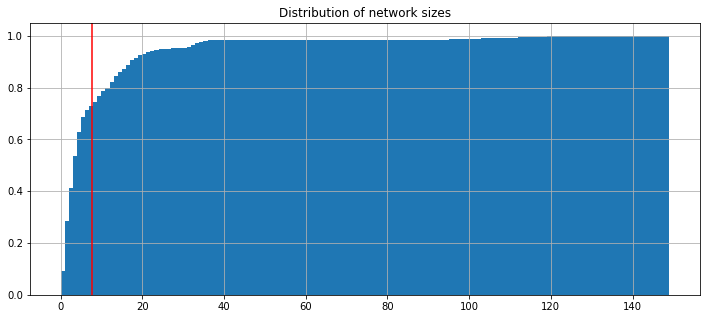

In [10]:
plt.hist(nets, cumulative=True, density=True, bins=2000)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

### Finally ready to simulate:
We will place the population that we have created, into various settings and societies in the upcoming simulations

In [11]:
SHOW_HEATMAP = True
IS_HTML5 = False
PREVALENCE = 1/50
SCALE_SETTINGS = dict(n_days = 60, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop, show_heatmap = SHOW_HEATMAP)
SCALE_SETTINGS

{'n_days': 60,
 'pop_size': 793139,
 'seed_size': 15862,
 'population': <codit.population.networks.city.CityPopulation at 0x7f69077b62b0>,
 'show_heatmap': True}

UK society, however, is characterized by testing bottlenecks:

In [12]:
o_UK = Outbreak(society.alternatives.UKSociety(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01)), Covid(name=COVID_TYPE), **SCALE_SETTINGS).simulate()

2021-03-08 12:57:18,846 WARNING:Using a pre-existing population - does it have the right network structure?
2021-03-08 12:57:34,864 INFO:Day 1, prop infected is 0.02, prop infectious is 0.0142
2021-03-08 13:00:01,460 INFO:Day 51, prop infected is 0.10, prop infectious is 0.0047
2021-03-08 13:00:25,056 INFO:Day 60, prop infected is 0.10, prop infectious is 0.0032


2021-03-08 13:00:25,718 INFO: Realized R0 of early infections is 0.85
2021-03-08 13:00:25,719 INFO: 10.2 percent of the proportion was infected during the epidemic


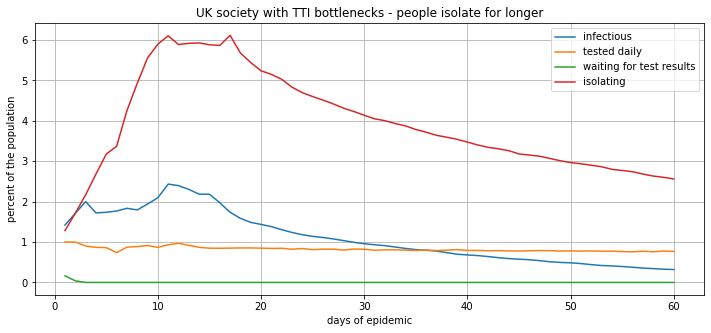

In [13]:
o_UK.plot(title='UK society with TTI bottlenecks - people isolate for longer')

Lets put that on a log scale:

2021-03-08 13:00:25,951 INFO: Realized R0 of early infections is 0.85
2021-03-08 13:00:25,952 INFO: 10.2 percent of the proportion was infected during the epidemic


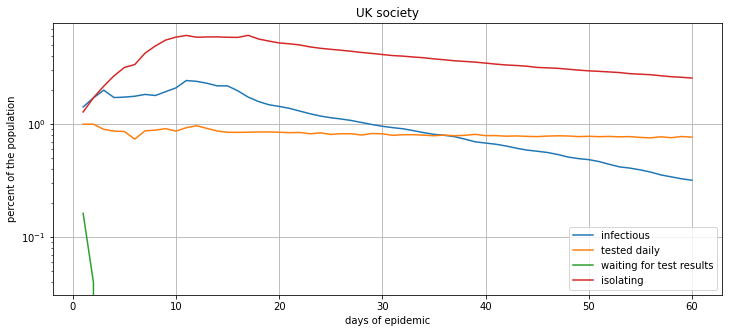

In [14]:
o_UK.plot(logy=True, title='UK society')

In [15]:
HTML(o_UK.outbreak_visualise(IS_HTML5))

2021-03-08 13:00:26,410 INFO:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


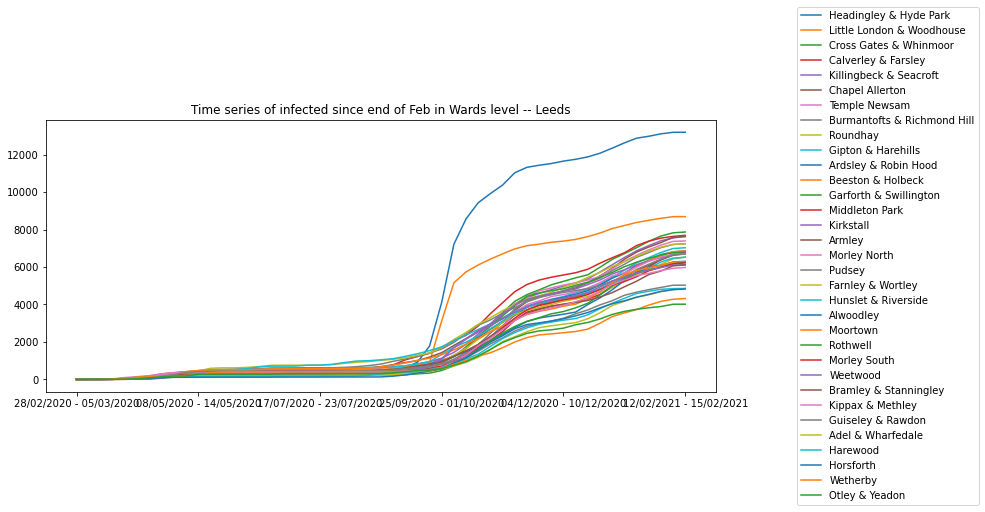

In [31]:
import pandas as pd
from codit import share_dir
DATA_PATH = share_dir() / 'codit' / 'data'
TIME_SERIES_WARDS = DATA_PATH / 'city' / 'population' / 'Timeseries_Leeds_wards.csv'

df_ts_wards = pd.read_csv(TIME_SERIES_WARDS,index_col=0)
df_aggregated_ts_wards = df_ts_wards.cumsum(axis=1)
order = np.argsort(df_aggregated_ts_wards.iloc[:,-1:].values, axis=None) # get the order of the last column
df_agg_sorted_ts_wards = df_aggregated_ts_wards.iloc[np.flip(order)]     # sort the dataframe in decending order
df_agg_sorted_ts_wards.T.plot(title="Time series of infected since end of Feb in Wards level -- Leeds", figsize=(12,5))
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.show()